# Predicting Tennis Match Outcomes

### INTRODUCTION 

**Background:**  

Having originated in the 12th century in Europe, tennis is now popularly played competitively and recreationally globally. The game, known as a match, involves using rackets to hit a ball across a net in the court between two players or pairs. Points are scored when a player is unable to return the incoming ball across the court or when the ball bounces twice on their side of the court. 

**Research question:**

What would the outcome of a match between two players be based on previous match statistics?

**Data Set:**

Data analysis will be done on the "Game results for Top 500 Players from 2017-2019" data set [1], collected by the Association of Tennis Professionals (ATP). In the data set, each observation is data for a specific match while each variable is a match or player statistic.

Variable definitions: [2] 
- tourney_id = unique identifier for each tournament 
- tourney_name = tournament name
- surface = court surface
- draw_size = total tournament draw size
- tourney_level = tour events
- tourney_date = eight digits (YYYYMMDD) usually the Monday of the tournament week
- match_num = a match-specific identifier
- winner_id/loser_id = player_id of the match winner/loser
- winner_seed/loser_seed = seed of match winner/loser
- winner_entry/loser_entry = 'WC' - wild card, 'Q' - qualifier, 'LL' - lucky loser, 'PR' - protected ranking, 'ITF' - ITF entry
- winner_name/loser_name = name of winner/loser
- winner_hand/loser_hand = dominant hand of winner/loser
- winner_ht/loser_ht = height in cm
- winner_ioc/loser_ioc = 3-character country code
- winner_age/loser_age = age in years
- score = final score
- best_of = '3' or '5' indicating the number of sets for this match
- round = round of tournament
- minutes = match length
- w_ace/l_ace = ace count
- w_df/l_df = double fault counts
- w_svpt/l_svpt = serve points
- w_1stIn/l_1stIn = first serves made
- w_1stWon/l_1stWon = first serve points won
- w_2ndWon/l_2ndWon = second serve points won
- w_SvGms/l_SvGms = service games won
- w_bpSaved/l_bpSaved = break points saved
- w_bpFaced/l_bpFaced = break points faced
- winner_rank/loser_rank = ATP or WTA rank, as of the tourney_date or most recent ranking date before tourney_date
- winner_rank_points/loser_rank_points = number of ranking points

### METHODS AND RESULTS

In [35]:
library(plyr)
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(1)

**Exploring the Data:**

The dataset was read from the internet and tidied to include only the variables needed in our preliminary data exploration. These variables were chosen based on their perceived influence on likelihood to win or lose a match [3]: (for both winner and loser) 
- Country of representation
- Age (years)
- Aces 
- Double fault counts 
- Serve points
- First serves made
- First serve points won
- Second serve points won
- Service games won
- Break points saved
- Break points faced

NOTE: rows in which W/O was found in the score column were removed. 
 
The tidied dataset was then split into training and testing sets and the training set was used for exploratory data analysis. A table of mean values and histograms for each variable were created. 

In [36]:
# Reading the data frame from a URL link

tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(tennis)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


_Table 1: Raw data_

In [37]:
# Wrangling and tidying the raw data

tennis <- filter(tennis, score!= "W/O")
tennis["Index"] <- seq(1, 6823) # "Index" column is added to keep track of matches and therefore players
tennis <- select(tennis, winner_ioc, loser_ioc, winner_age, loser_age, w_ace, w_df, w_svpt, w_1stIn, w_1stWon, 
    w_2ndWon, w_SvGms, w_bpSaved, w_bpFaced, l_ace, l_df, l_svpt, l_1stIn, l_1stWon, l_2ndWon, l_SvGms, 
    l_bpSaved, l_bpFaced)

# Seperate the statistics for winning and losing players

tennis_w <- select(tennis, starts_with("w")) 
tennis_w["Outcome"] <- "W"
colnames(tennis_w) = gsub("w_","",colnames(tennis_w))
colnames(tennis_w) = gsub("winner_","",colnames(tennis_w))
tennis_w["Index"] <- seq(1, 6823)

tennis_L <- select(tennis, starts_with("l"))
tennis_L["Outcome"] <- "L"
colnames(tennis_L) = gsub("l_","",colnames(tennis_L))
colnames(tennis_L) = gsub("loser_","",colnames(tennis_L))
tennis_L["Index"] <- seq(1, 6823)

# Rejoin the statistics for winning and losing players

tennis <- rbind(tennis_w, tennis_L)

# Changing the column names that start with numbers

names(tennis)[6] <- "firstIn"
names(tennis)[7] <- "firstWon"
names(tennis)[8] <- "secondWon"

In [38]:
# Split the data set into training and testing sets

tennis_split <- initial_split(tennis, prop = 0.75, strata = Outcome)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split) 
tennis_train

ioc,age,ace,df,svpt,firstIn,firstWon,secondWon,SvGms,bpSaved,bpFaced,Outcome,Index
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
JPN,29.00479,3,3,77,44,31,17,13,3,6,W,1
RUS,22.88569,10,1,52,33,28,14,10,0,1,W,2
JPN,29.00479,2,2,47,33,26,9,8,2,2,W,3
RUS,22.88569,12,3,105,68,48,25,16,8,8,W,5
FRA,31.88227,10,8,94,58,44,18,16,4,8,W,6
JPN,29.00479,5,2,59,47,37,9,12,0,1,W,7
FRA,33.70568,11,3,64,37,30,11,10,4,7,W,8
AUS,19.86858,1,1,49,38,29,8,9,0,0,W,9
RUS,22.88569,16,2,54,34,27,13,10,0,1,W,10


_Table 2: Exploratory data analysis variables and outcome (prediction class variable)_

<span style="color:red">The following exploratory data analysis only uses the training set</span>

In [39]:
# Exploratory data analysis table

means_table <- tennis_train %>%
    select(-ioc, -Outcome, -Index) %>%
    map_df(mean, na.rm = TRUE)
means_table

age,ace,df,svpt,firstIn,firstWon,secondWon,SvGms,bpSaved,bpFaced
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27.56839,6.551646,3.105848,81.54604,50.22536,36.05101,15.91843,12.76796,4.128354,6.768943


_Table 3: Variable means_

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


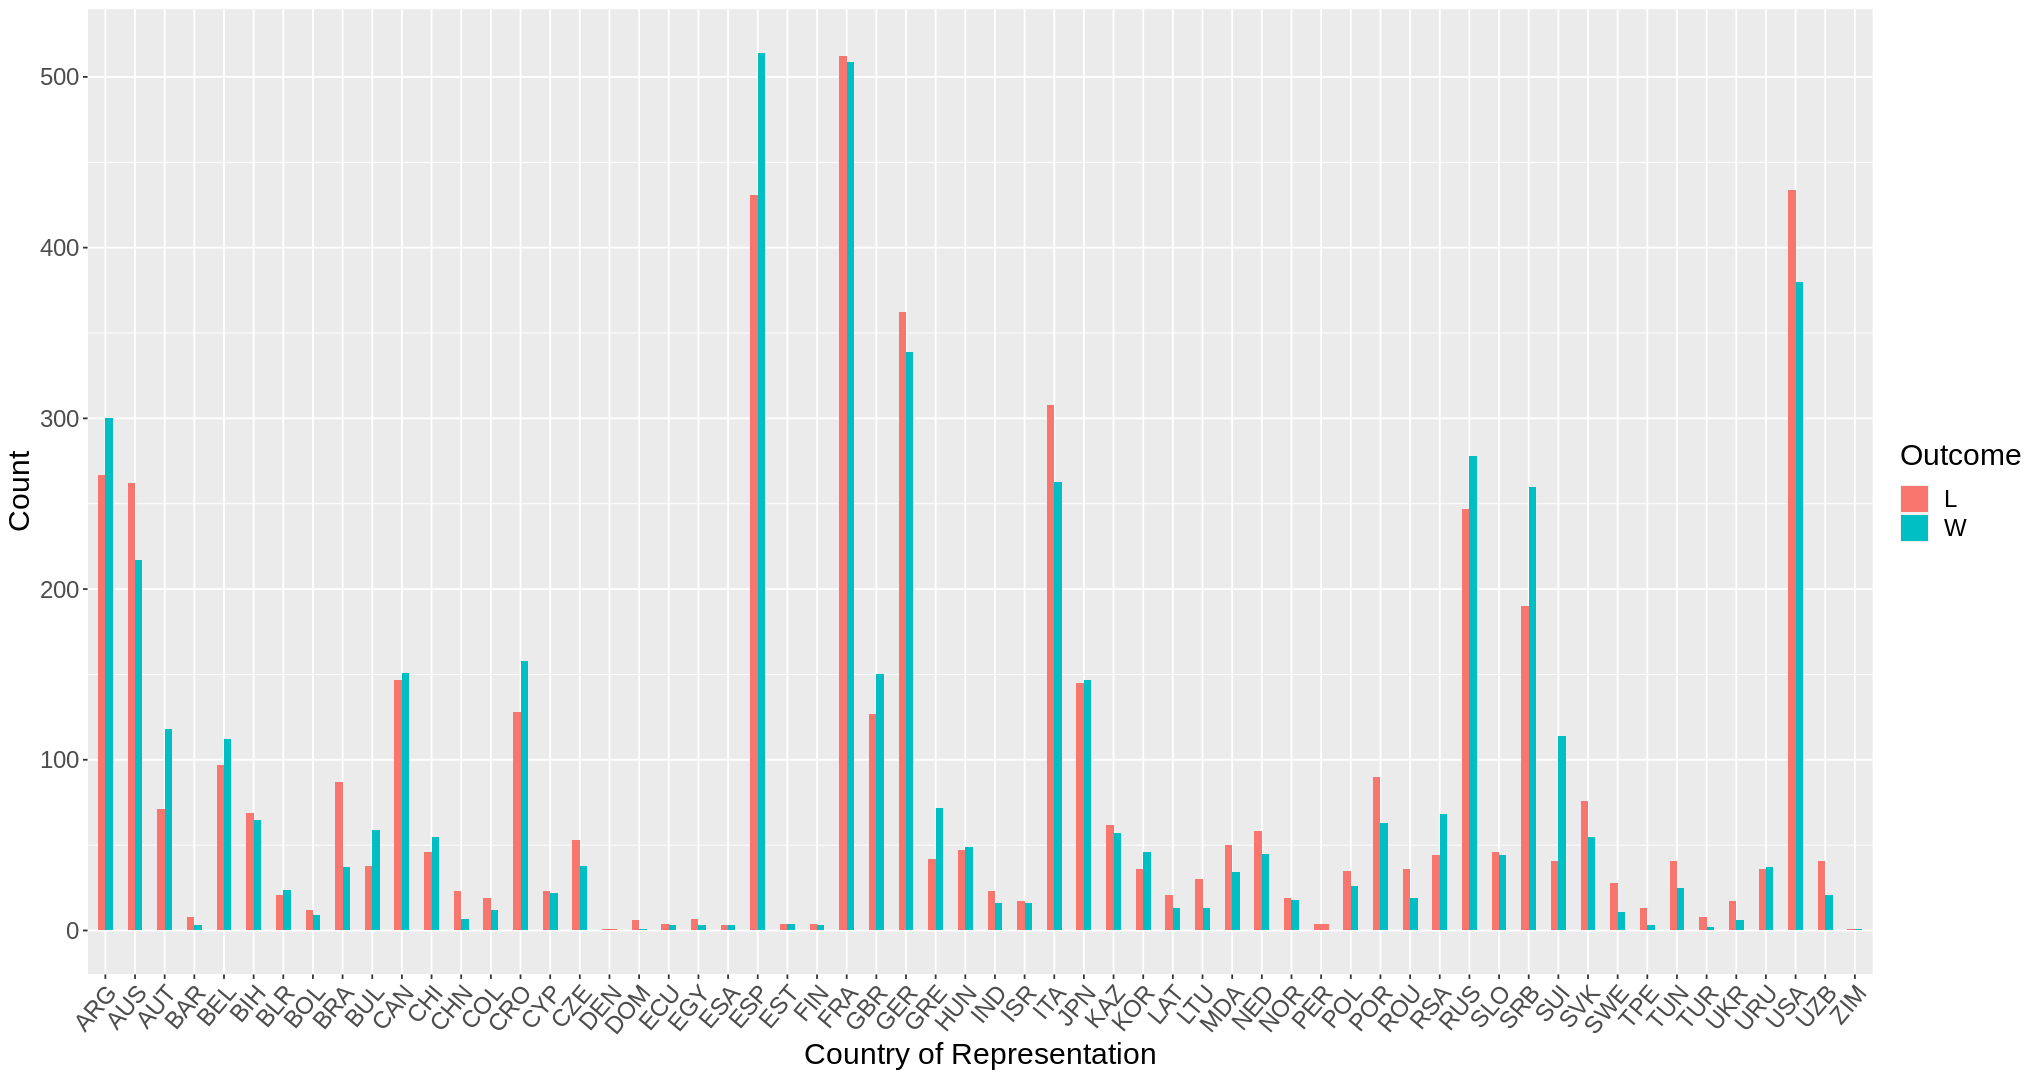

In [14]:
# Exploratory data analysis plot 1:

options(repr.plot.width = 17, repr.plot.height = 9) 

ioc_plot <- tennis_train %>% 
   ggplot(aes(x = ioc, fill = Outcome)) + 
   geom_histogram(stat = "count", position = position_dodge(), width = .5) + 
   xlab("Country of Representation") +
   ylab("Count") +
   theme(text = element_text(size = 18)) +
   theme(axis.text.x = element_text(angle = 50, hjust = 1)) + 
   theme(plot.title = element_text(hjust = 0.5))
ioc_plot

_Figure 1: Histogram of the players' country of representation coloured by match outcome_

Some countries have higher win rates than others, for example Spain and France, however **there does not appear to be a pattern of certain countries producing more winners or losers.**

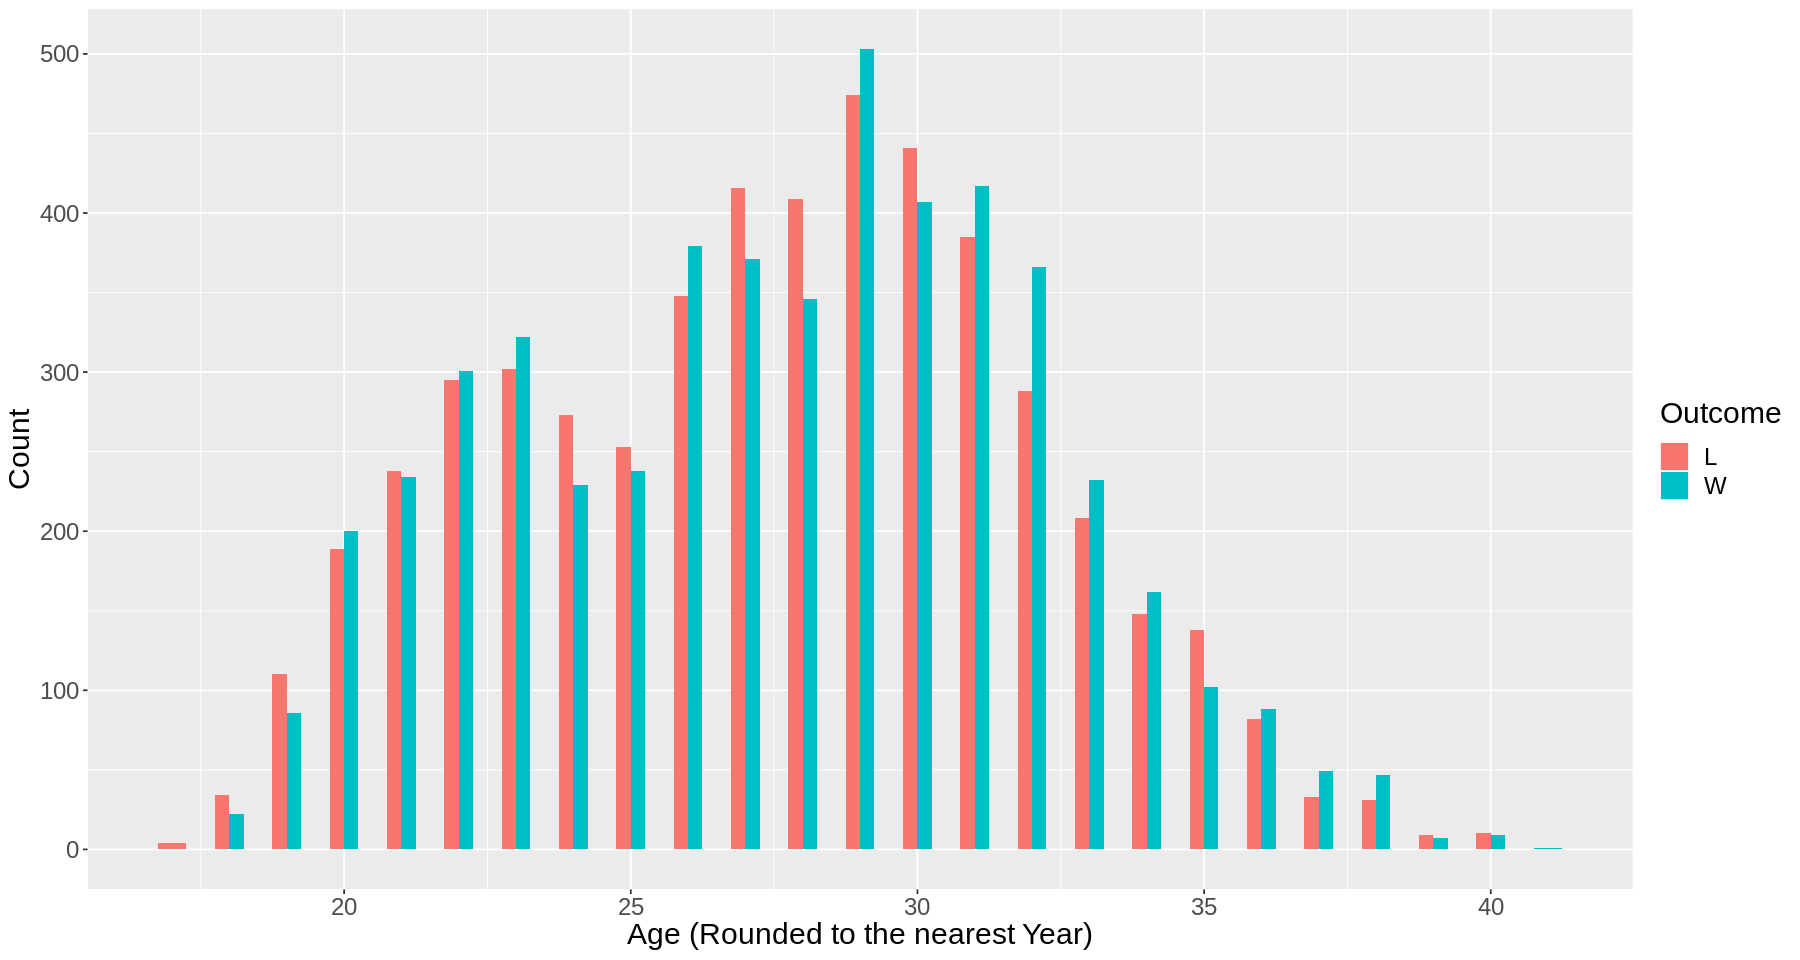

In [15]:
# Exploratory data analysis plot 2:

options(repr.plot.width = 15, repr.plot.height = 8) 

age_plot <- tennis_train %>% 
   ggplot(aes(x = round(age), fill = Outcome)) + 
   geom_bar(stat = "count", position = position_dodge(), width = 0.5) + 
   xlab("Age (Rounded to the nearest Year)")+
   ylab("Count") +
   theme(text = element_text(size = 18)) +
   theme(plot.title = element_text(hjust = 0.5))
age_plot

_Figure 2: Histogram of the player's age coloured by match outcome_

Both distributions are bimodal with the higher peak at 30 years or age and the smaller peak at 23 years of age. The distributions range between roughly 17 to 40 years. **There is no significant difference in distribution of winners’ age versus losers’ age.**

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


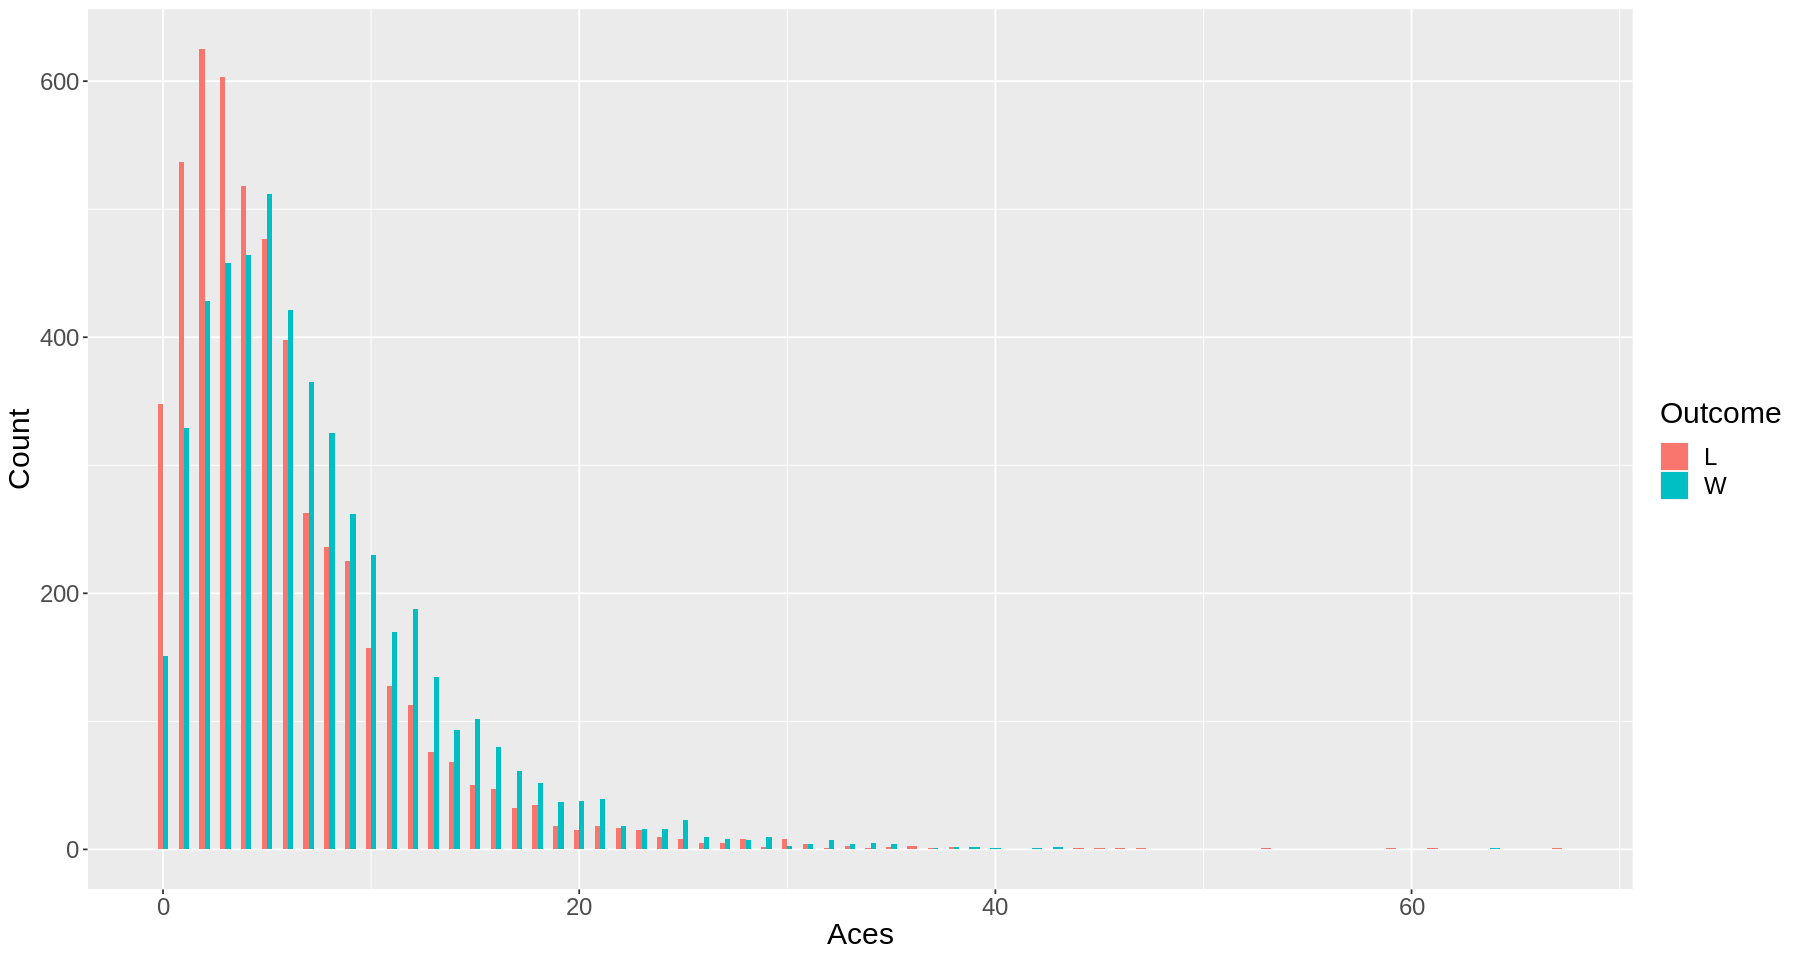

In [16]:
# Exploratory data analysis plot 3:

options(repr.plot.width = 15, repr.plot.height = 8) 

ace_plot <- tennis_train %>% 
   ggplot(aes(x = ace, fill=Outcome)) + 
   geom_histogram(stat = "count", position=position_dodge(), width = 0.5) + 
   xlab("Aces") +
   ylab("Count") +
   theme(text = element_text(size = 18)) + 
   theme(plot.title = element_text(hjust = 0.5))
ace_plot

_Figure 3: Histogram of players' number of aces coloured by match outcome_

The distributions are unimodal and right-skewed. The losers’ distribution has a center at approximately 2 aces while the winners’ distribution has a center at approximately 4 aces. Both distributions have similar ranges between 0 to 70 aces. 

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


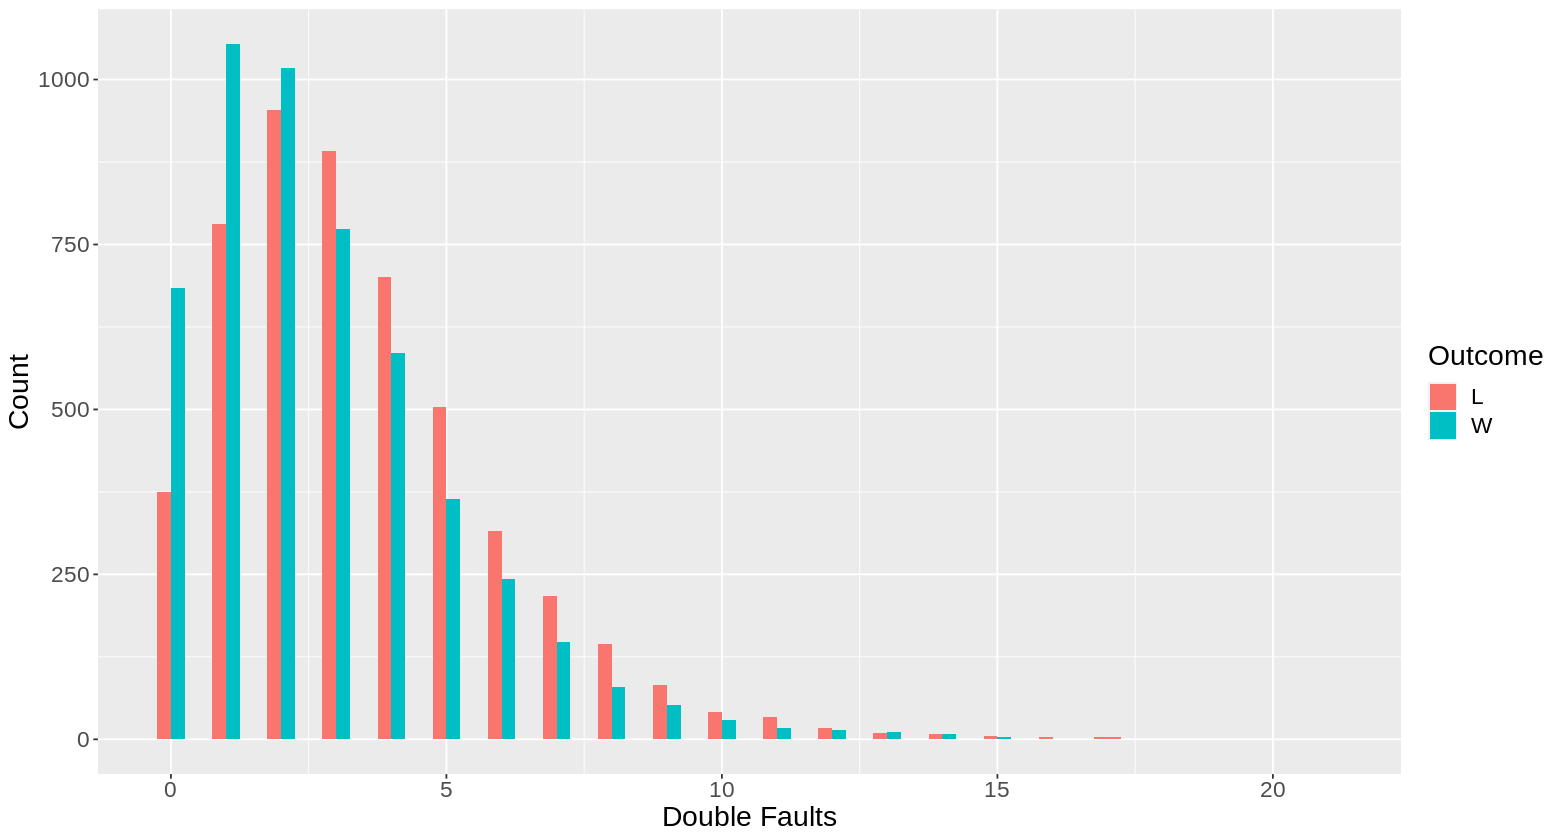

In [17]:
# Exploratory data analysis plot 4:

options(repr.plot.width = 13, repr.plot.height = 7) 

df_plot <- tennis_train %>% 
   ggplot(aes(x = df, fill = Outcome)) + 
   geom_histogram(stat = "count", position=position_dodge(), width = 0.5) + 
   xlab("Double Faults") +
   ylab("Count") +
   theme(text = element_text(size = 17)) + 
   theme(plot.title = element_text(hjust = 0.5))
df_plot

_Figure 4: Histogram of players' number of double faults coloured by match outcome_

Both distributions are unimodal and right-skewed, with a center at approximately 3 double faults and similar ranges between 0 to 20 double faults. **There is no significant difference in distribution of winners’ versus losers’ double fault counts.**

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


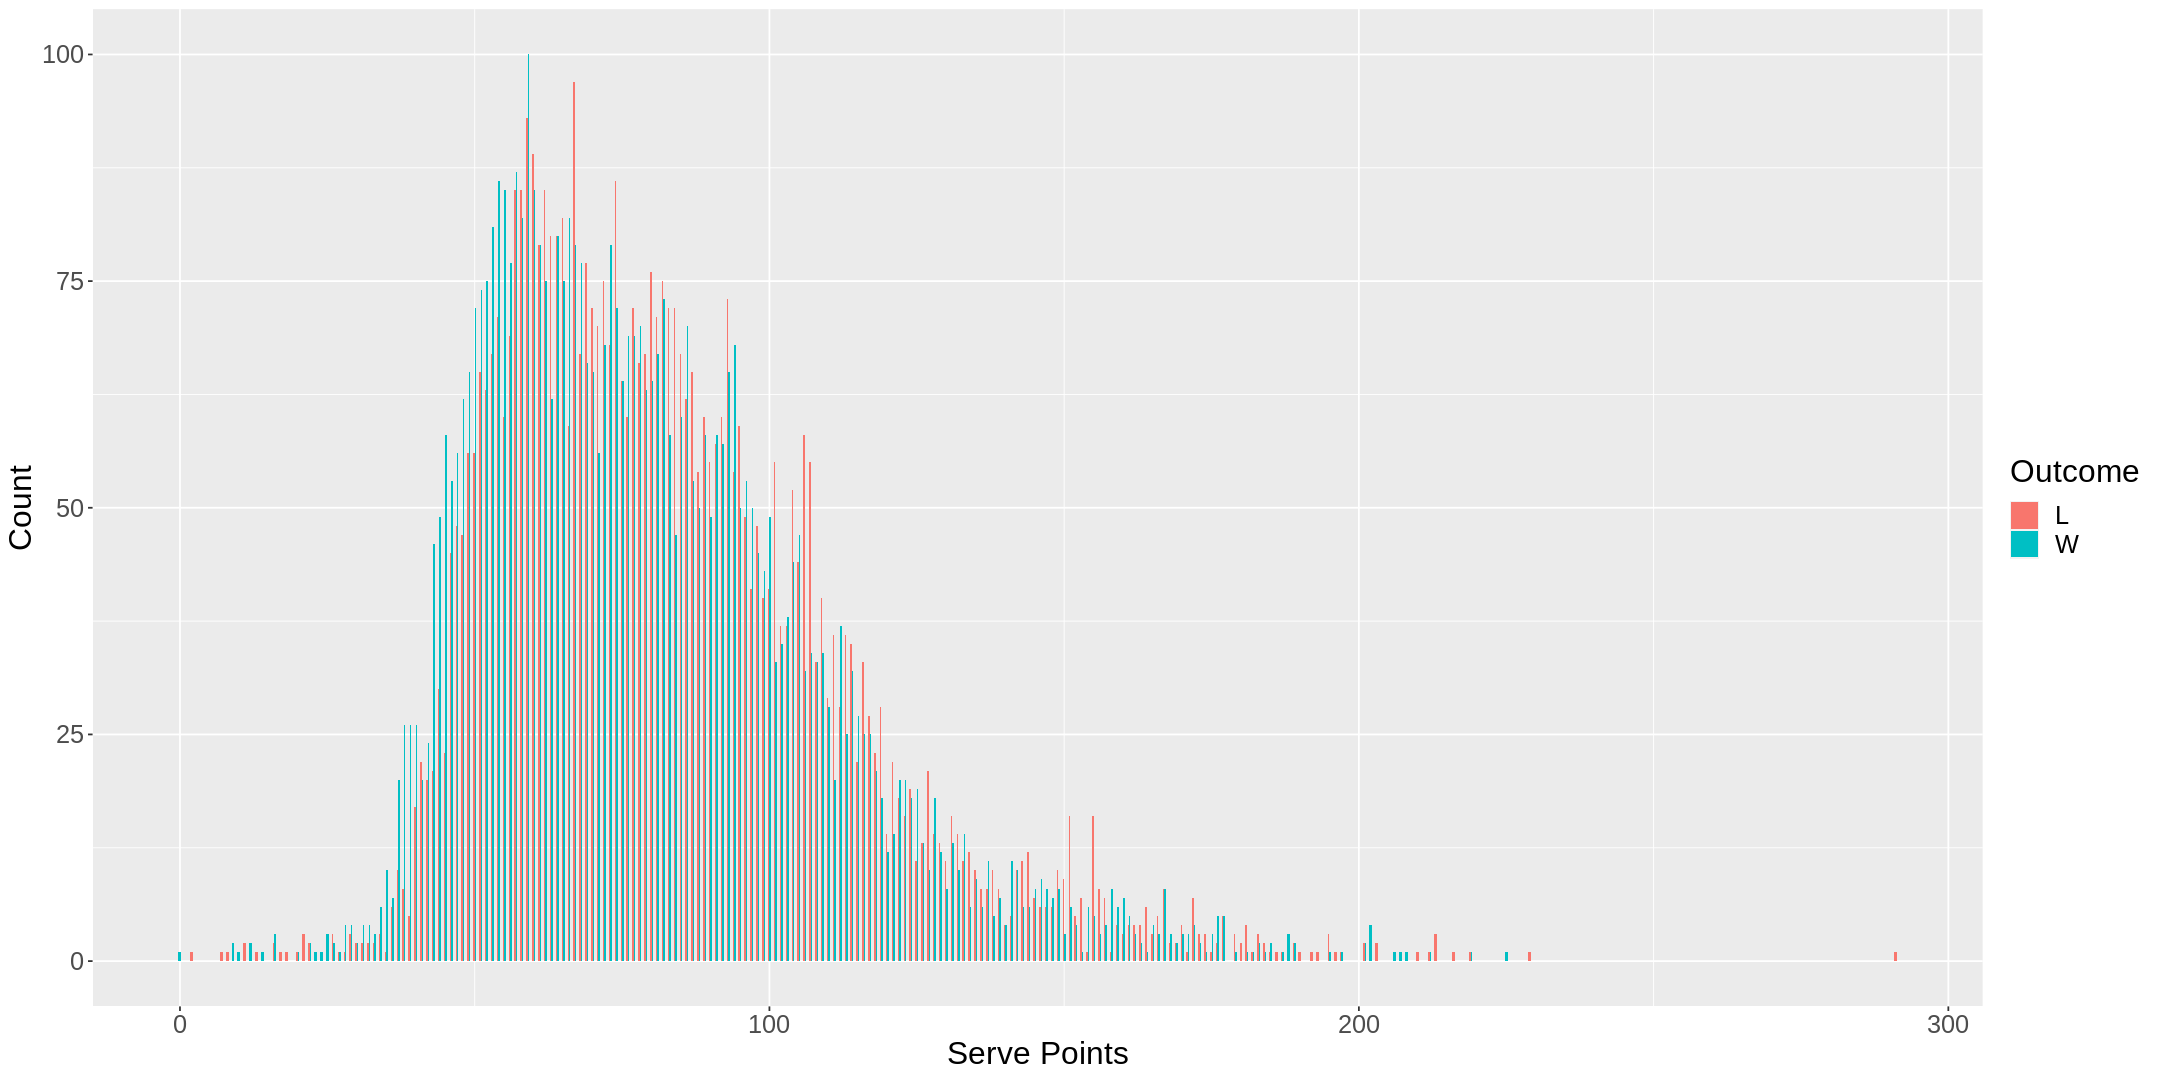

In [18]:
# Exploratory data analysis plot 5: 

options(repr.plot.width = 18, repr.plot.height = 9)

svpt_plot <- tennis_train %>% 
   ggplot(aes(x = svpt, fill = Outcome)) + 
   geom_histogram(stat = "count", position = position_dodge(), width = 0.5) + 
   xlab("Serve Points") +
   ylab("Count") +
   theme(text = element_text(size = 19)) +
   theme(plot.title = element_text(hjust = 0.5))
svpt_plot

_Figure 5: Histogram of players' number of serve points coloured by match outcome_

Both distributions are unimodal and slightly right-skewed with a center at approximately 70 serve points and a range between 0 to 250 serve points. **There is no significant difference in distribution of winners’ versus losers’ serve point counts.**

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


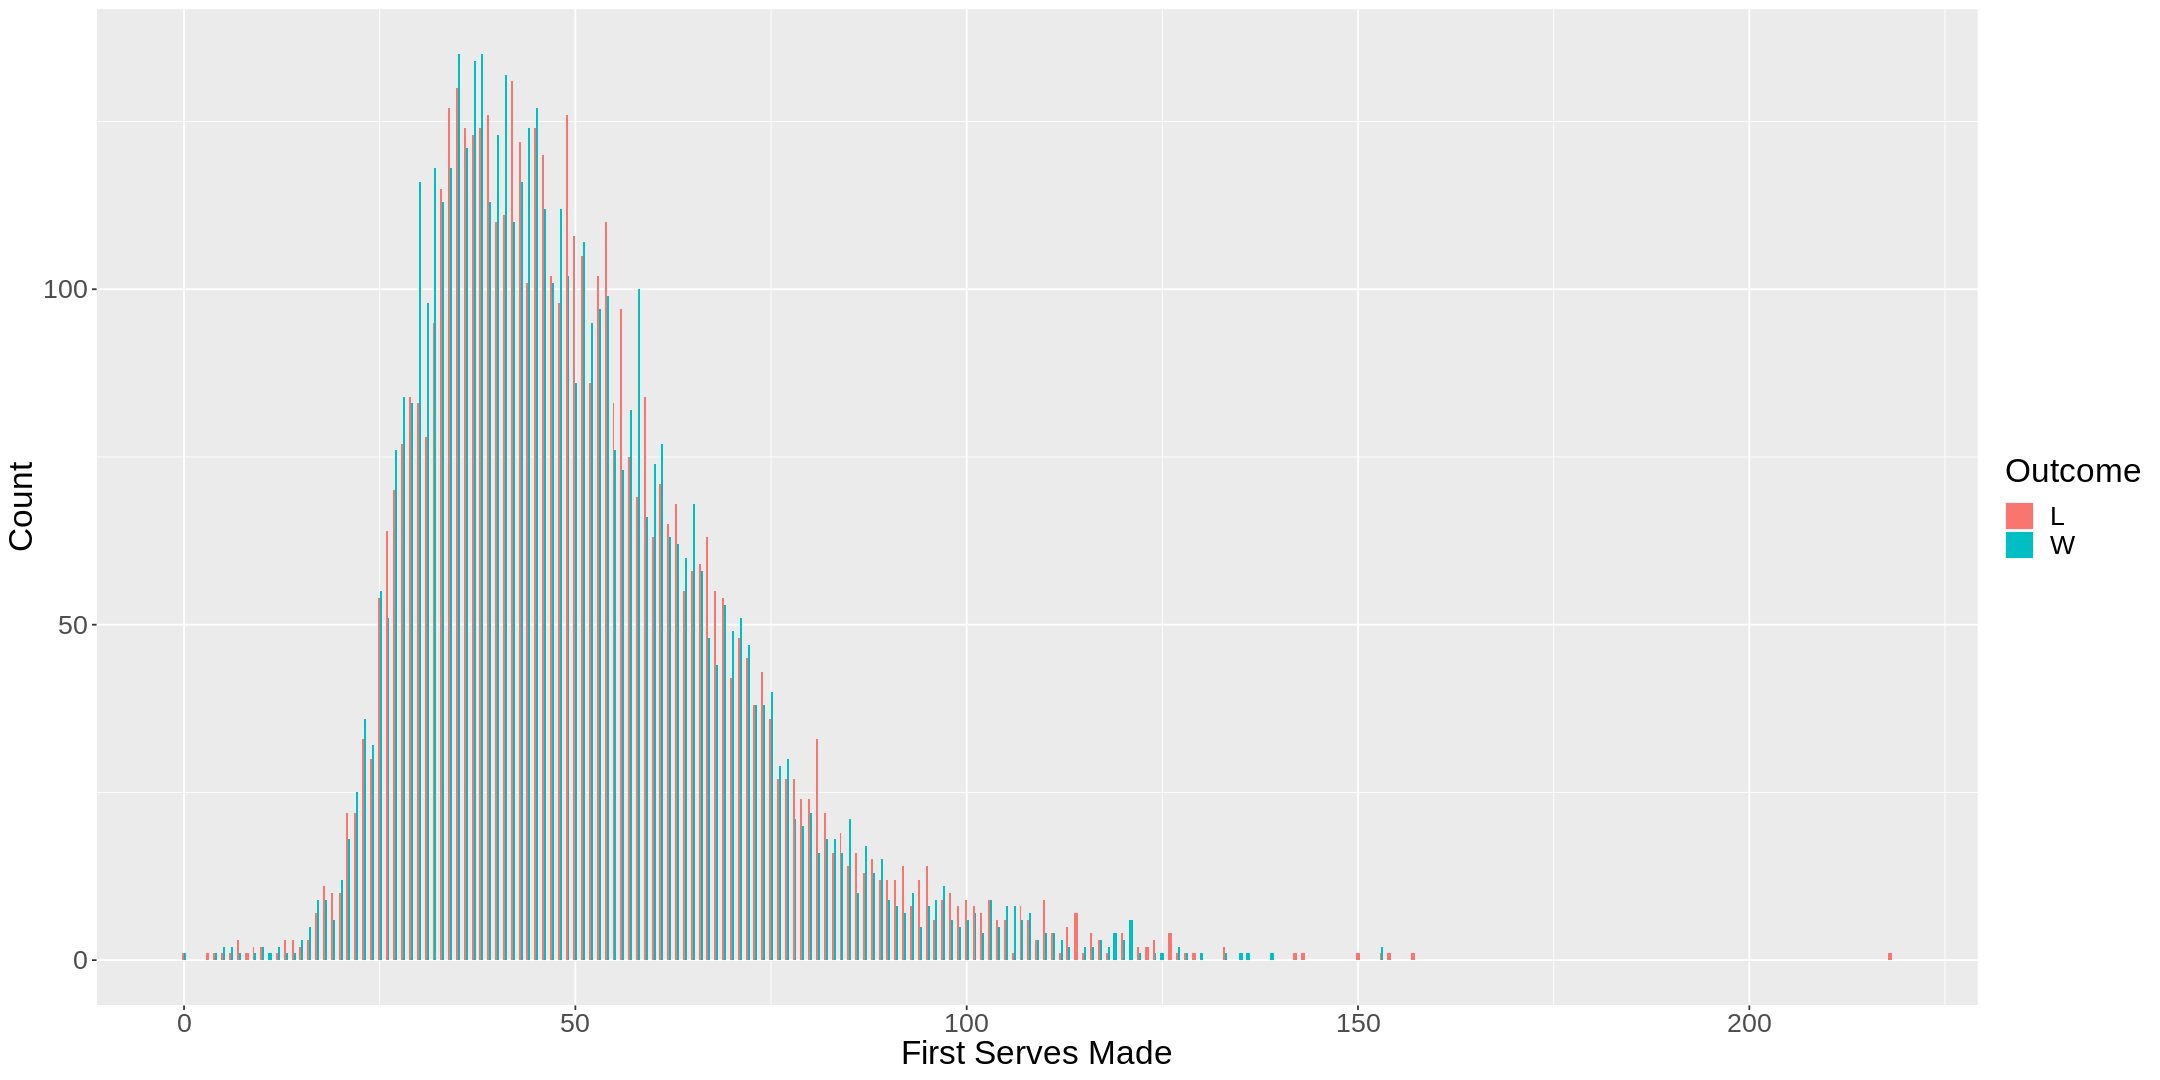

In [19]:
# Exploratory data analysis plot 6:

options(repr.plot.width = 18, repr.plot.height = 9)

firstIn_plot <- tennis_train %>% 
   ggplot(aes(x = firstIn, fill=Outcome)) + 
   geom_histogram(stat = "count", position = position_dodge(), width = .5) + 
   xlab("First Serves Made") +
   ylab("Count") +
   theme(text = element_text(size = 20)) +
   theme(plot.title = element_text(hjust = 0.5))
firstIn_plot

_Figure 6: Histogram of players' number of first serves made coloured by match outcome_

Both distributions are unimodal and slightly right-skewed with a center at approximately 50 first serves made. They range from 0 to 160 first serves made, with **no significant difference between winners’ and losers’ distributions.**

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


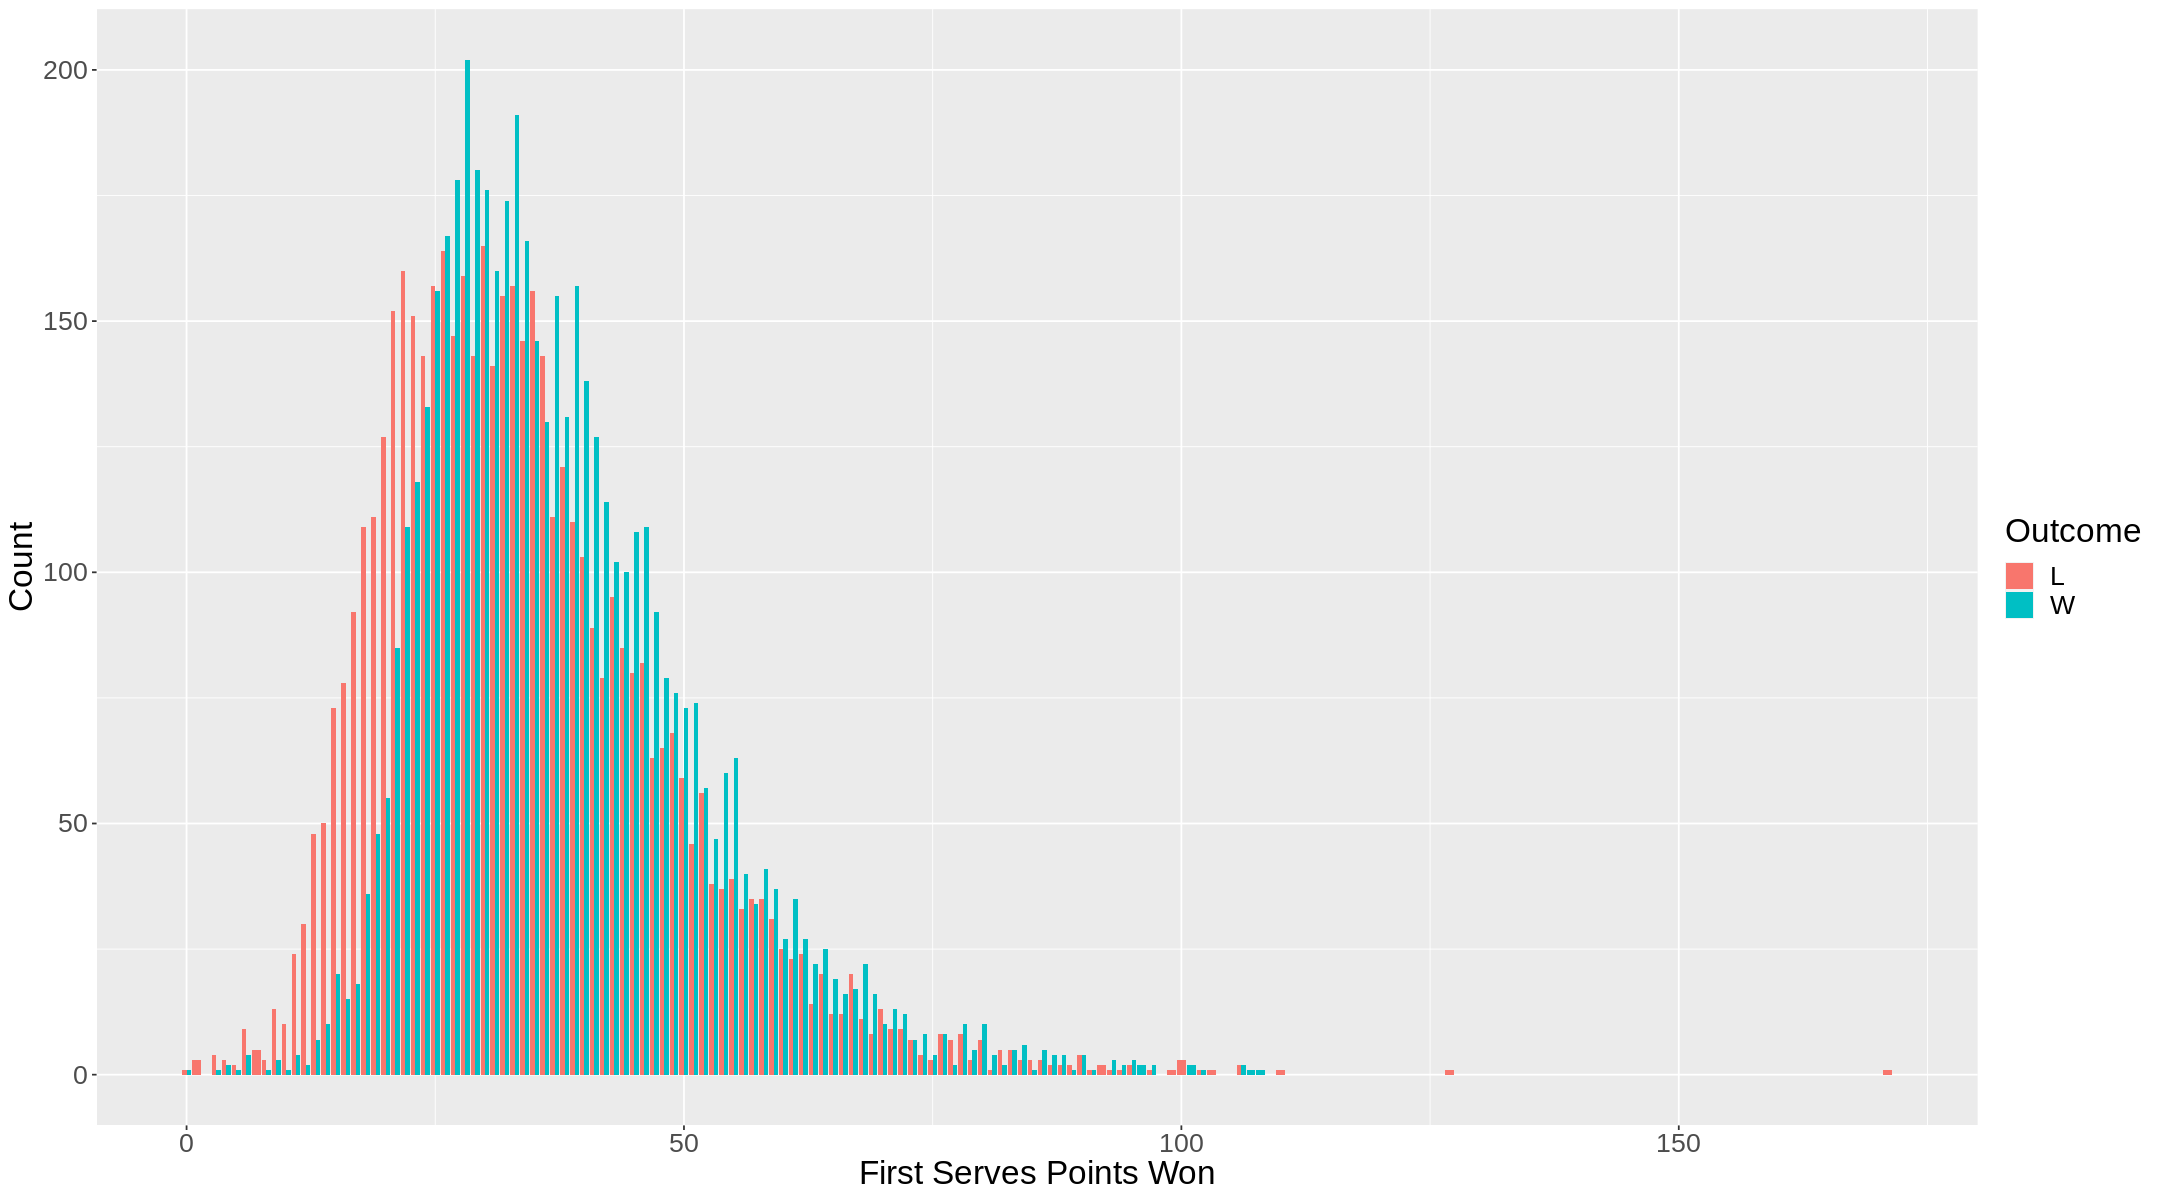

In [20]:
# Exploratory data analysis plot 7:

options(repr.plot.width = 18, repr.plot.height = 10)

firstWon_plot <- tennis_train %>% 
   ggplot(aes(x = firstWon, fill = Outcome)) + 
   geom_histogram(stat="count", position = position_dodge()) + 
   xlab("First Serves Points Won") +
   ylab("Count") +
   theme(text = element_text(size = 20)) + 
   theme(plot.title = element_text(hjust = 0.5))
firstWon_plot

_Figure 7: Histogram of players' number of first serves points won coloured by match outcome_

Both distributions are unimodal and right-skewed, with a range between 0 to approximately 110 first serve points won. The losers’ distribution has a center at about 35 first serve points won while the winners’ distribution has a center at about 30 first serve points won. 

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


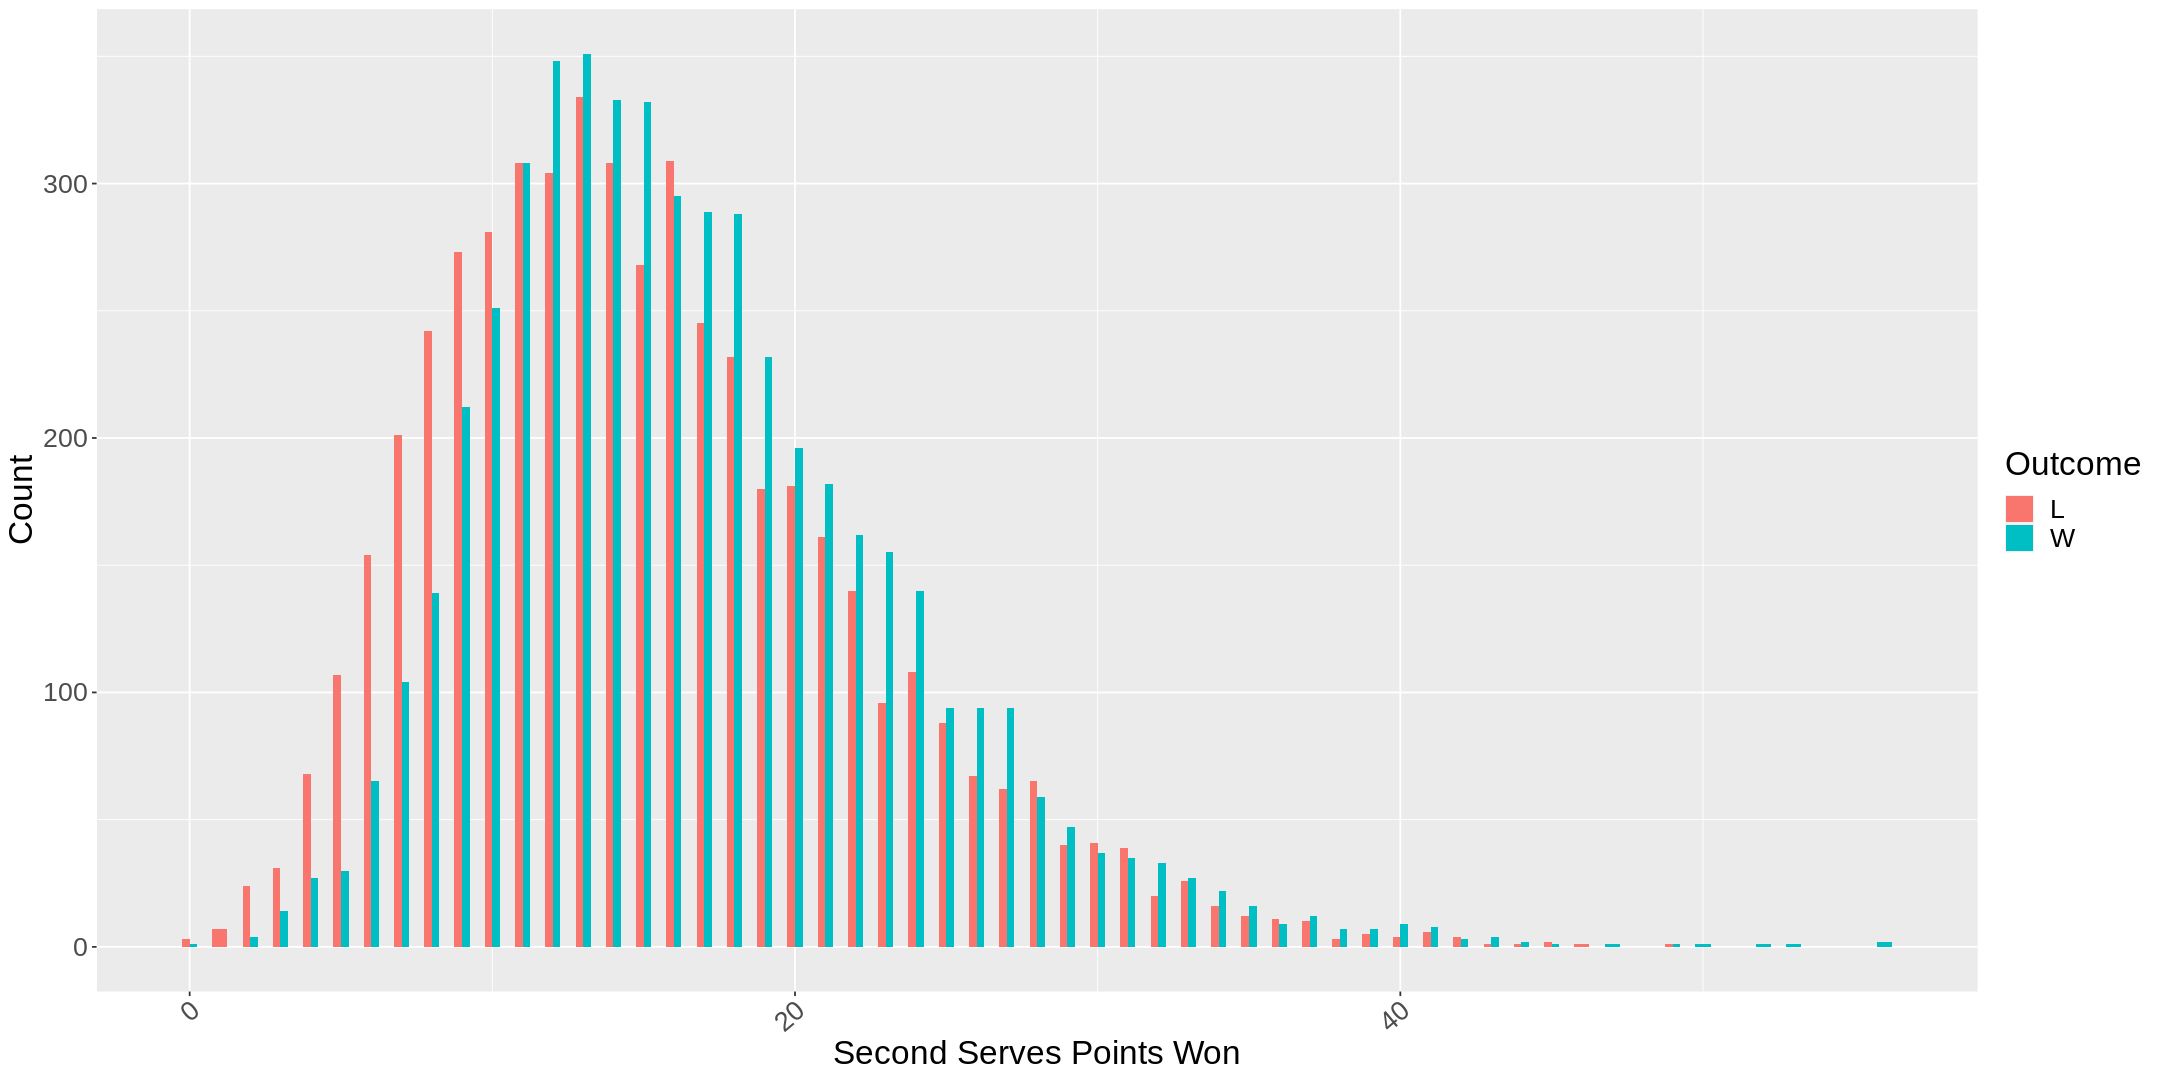

In [21]:
# Exploratory data analysis plot 8:

options(repr.plot.width = 18, repr.plot.height = 9)

secondWon_plot <- tennis_train %>% 
   ggplot(aes(x = secondWon, fill=Outcome)) + 
   geom_histogram(stat = "count", position=position_dodge(), width = .5) + 
   xlab("Second Serves Points Won") +
   ylab("Count") +
   theme(text = element_text(size = 20)) +
   theme(axis.text.x = element_text(angle = 40, hjust = 1)) + 
   theme(plot.title = element_text(hjust = 0.5))
secondWon_plot

_Figure 8: Histogram of players' number of second serves points won coloured by match outcome_

Both distributions are unimodal and slightly right-skewed with a range between 0 to 60 second serve points won. The losers’ distribution has a center at about 14 second serve points won while the winners’ distribution has a center at about 16 second serve points won. 

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


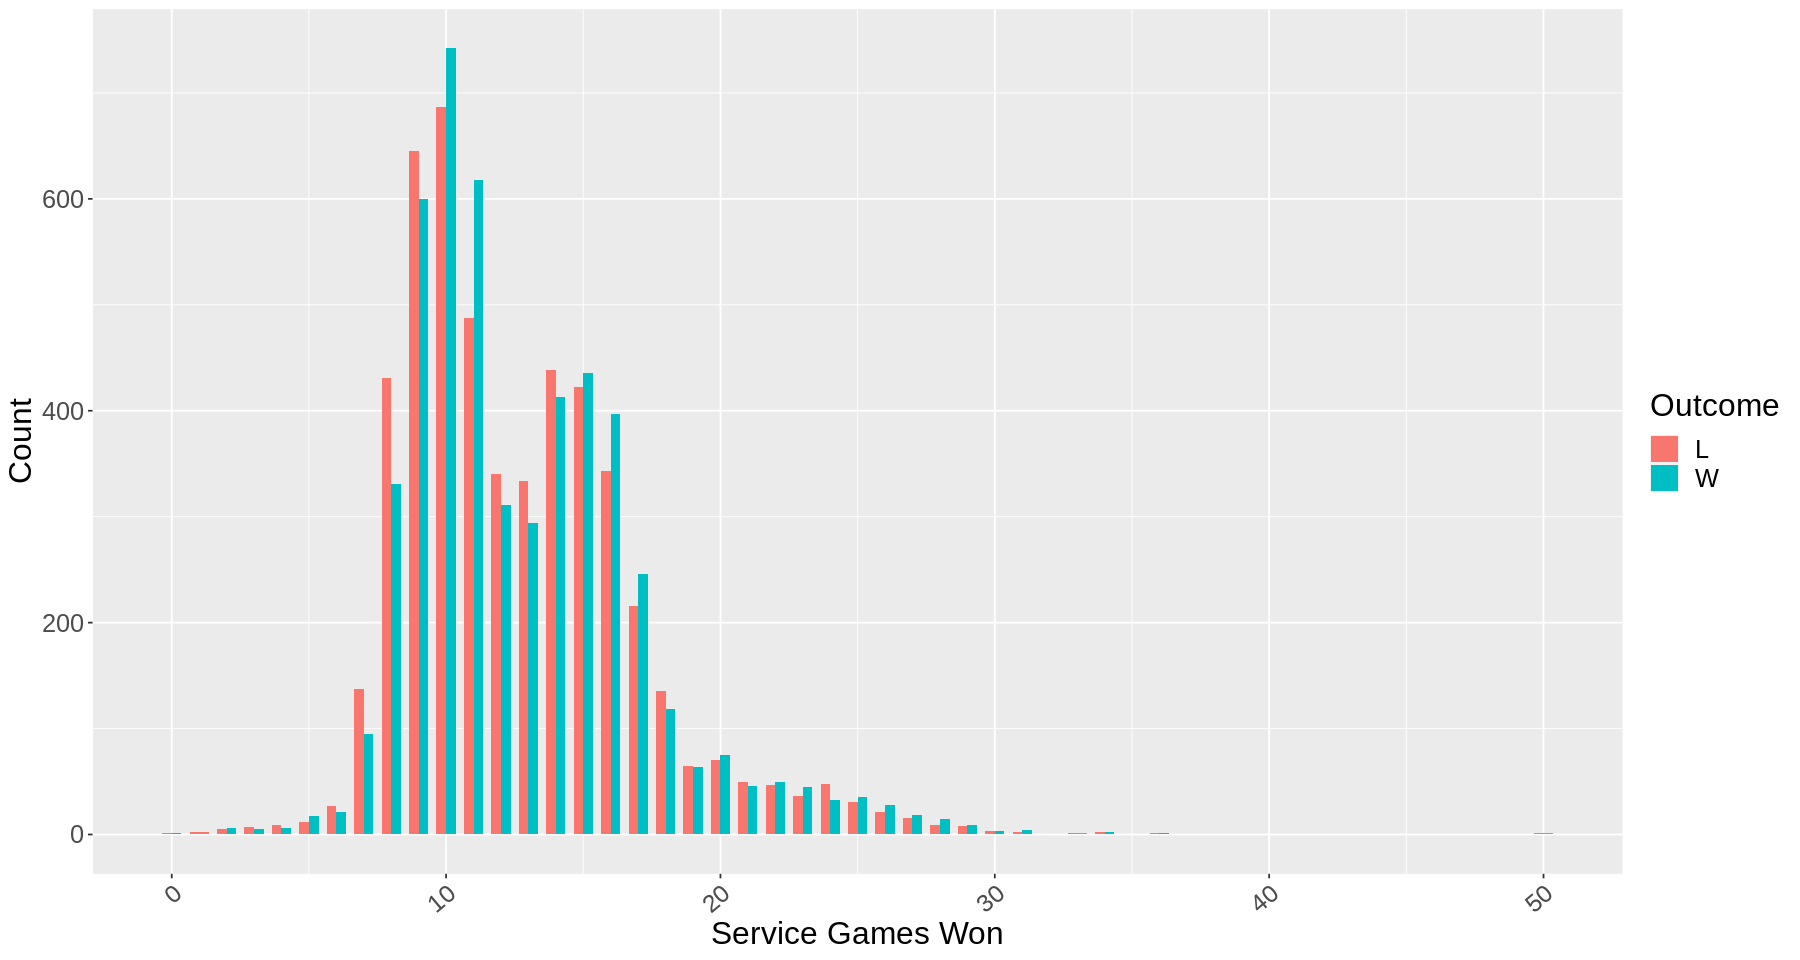

In [22]:
# Exploratory data analysis plot 9:

options(repr.plot.width = 15, repr.plot.height = 8)

SvGms_plot <- tennis_train %>% 
   ggplot(aes(x = SvGms, fill=Outcome)) + 
   geom_histogram(stat = "count", position=position_dodge(), width = .7) + 
   xlab("Service Games Won") +
   ylab("Count") +
   theme(text = element_text(size = 19)) +
   theme(axis.text.x = element_text(angle = 40, hjust = 1)) + 
   theme(plot.title = element_text(hjust = 0.5))
SvGms_plot

_Figure 9: Histogram of players' number of service games won coloured by match outcome_

Both distributions are bimodal with the higher peak at 10 service games won and the smaller peak at 15 service games won. The distributions range from 0 to 35 service games won, with **no significant difference between winners’ and losers’ distributions.**

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


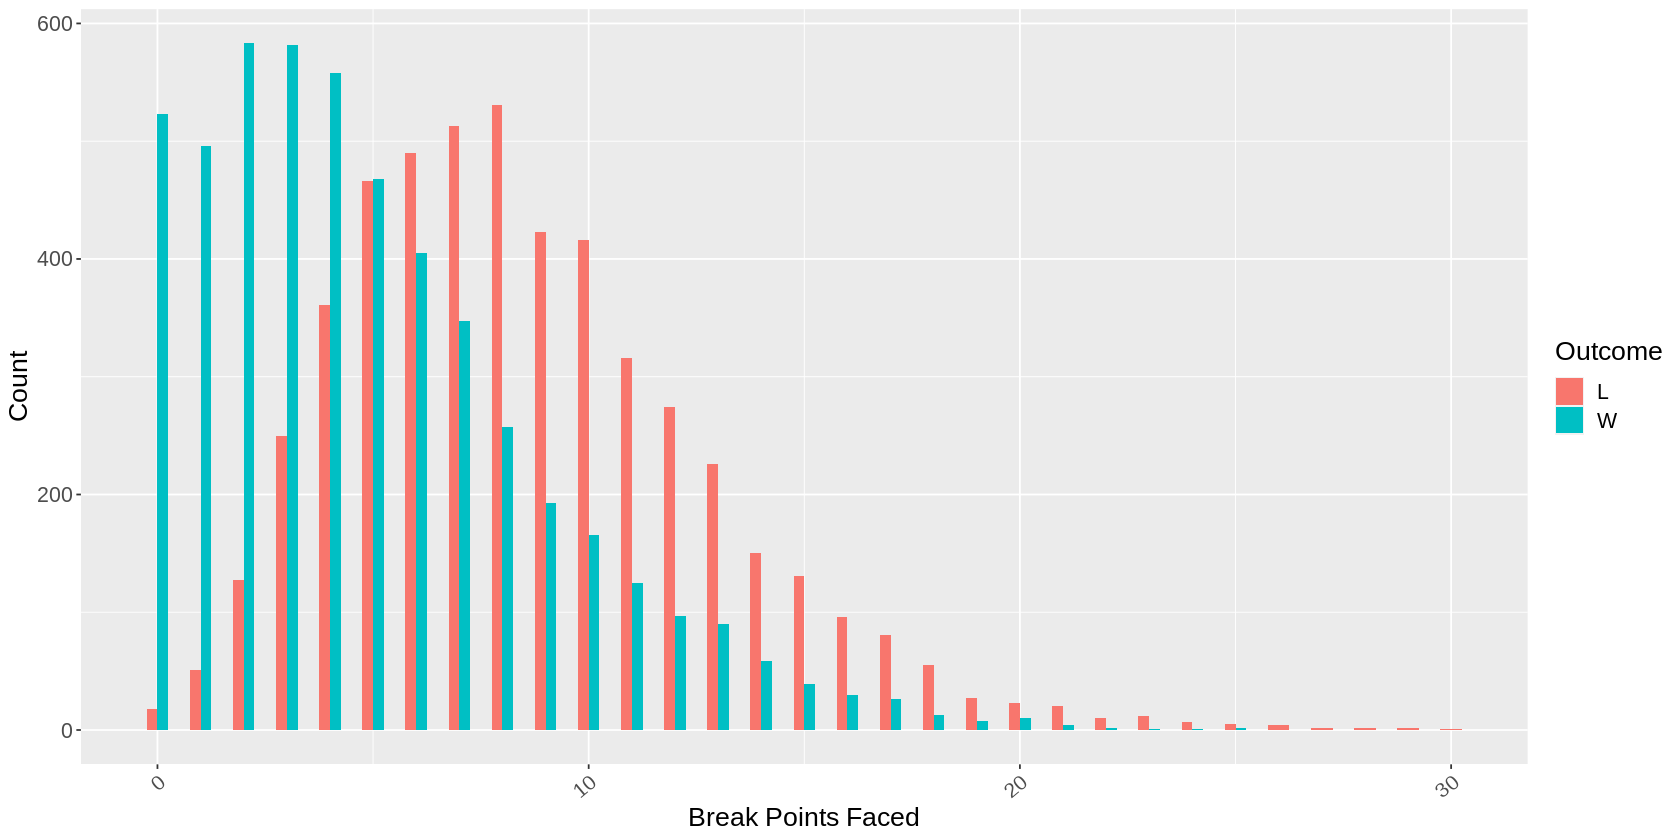

In [23]:
# Exploratory data analysis plot 10:

options(repr.plot.width = 14, repr.plot.height = 7)

bpFaced_plot <- tennis_train %>% 
   ggplot(aes(x = bpFaced, fill=Outcome)) + 
   geom_histogram(stat = "count", position=position_dodge(), width = .5) + 
   xlab("Break Points Faced") +
   ylab("Count") +
   theme(text = element_text(size = 16)) +
   theme(axis.text.x = element_text(angle = 40, hjust = 1)) + 
   theme(plot.title = element_text(hjust = 0.5))
bpFaced_plot

_Figure 10: Histogram of players' number of break points faced coloured by match outcome_

Both distributions are unimodal and right-skewed. The losers’ distribution has a center at 9 breakpoints faced and a range of 0 to 30 breakpoints faced. The winners’ distribution has a center at 4 breakpoints faced and a range of 0 to 25 breakpoints faced. 

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Removed 61 rows containing non-finite values (stat_count).”


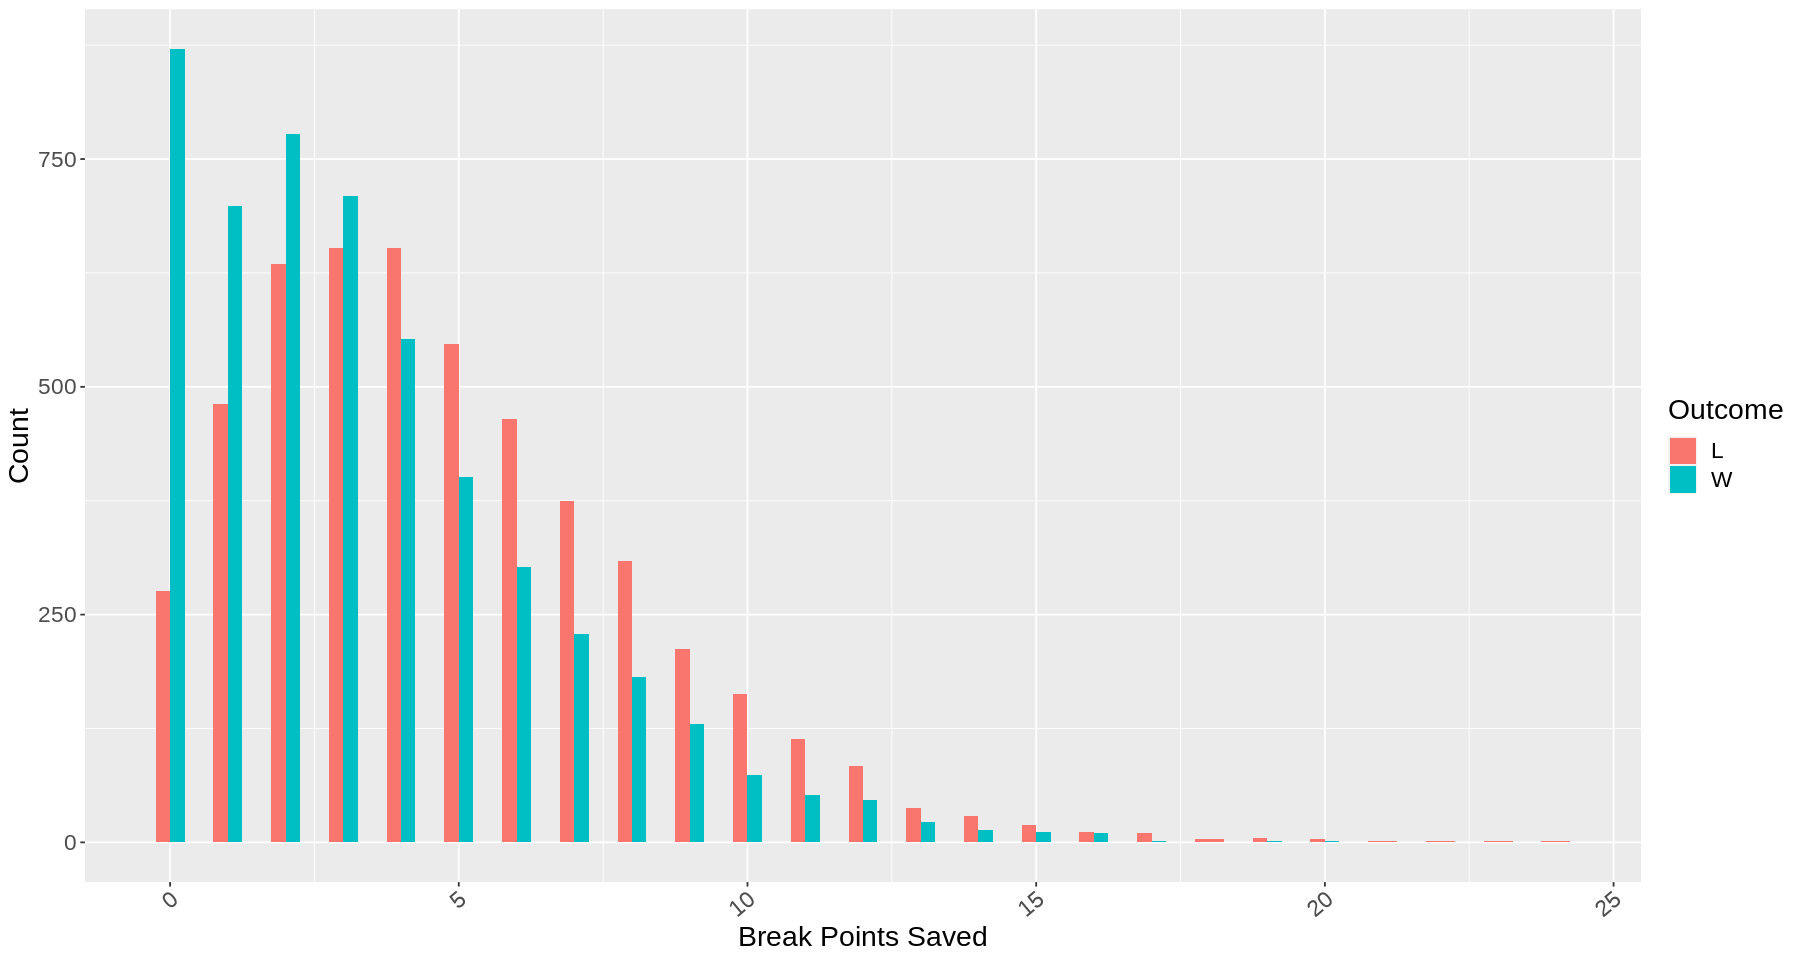

In [24]:
# Exploratory data analysis plot 11:

options(repr.plot.width = 15, repr.plot.height = 8)

bpSaved_plot <- tennis_train %>% 
   ggplot(aes(x = bpSaved, fill=Outcome)) + 
   geom_histogram(stat = "count", position=position_dodge(), width = .5) + 
   xlab("Break Points Saved") +
   ylab("Count") +
   theme(text = element_text(size = 17)) +
   theme(axis.text.x = element_text(angle = 40, hjust = 1)) + 
   theme(plot.title = element_text(hjust = 0.5))
bpSaved_plot

_Figure 11: Histogram of players' number of break points saved coloured by match outcome_

The distributions are unimodal and right-skewed. The losers’ distribution has a center at 4 breakpoints saved and a range between 0 to 25 breakpoints saved. The winners’ distribution has a center at approximately 3 breakpoints saved and a range between 0 to 20 breakpoints saved.  

**Classification:**

The final predictors chosen for classification were only the variables whose exploratory data analysis plots showed significant differences between winners’ and losers’ distributions: (for both winner and loser) 
- Aces
- First serve won
- Second serve won
- Breakpoint faced
- Breakpoint saved 

NOTE: First serve won and second serve won were added together and divided by Serve point to give a percentage. Aces, Breakpoint faced, and Breakpoint saved were also each divided by Serve point to give a percentage. Since all the predictors were converted to a percentage, scaling was not needed. We chose to standardize using percentages to account for the potential upscaling effect of longer match length. Serve point was utilized as the denominator in percentage calculations since all our chosen predictors are serve-based statistics. 
 
A K-nearest neighbors classification model was made to evaluate the outcome of a match for a tennis player using match data for our chosen predictors. This could be applied either to an ongoing match where we have data from earlier on in the match or aggregate data from previous matches to predict that if a player were to keep their current form, should they win the match or not. A 5-fold cross validation was done to tune K. Based on Figure 12, K = 250 was chosen since that is the approximate graph peak where the K value has the highest accuracy.

In [25]:
# Creating new percentages columns in training set

tennis_train_final <- tennis_train %>% 
drop_na()%>%
mutate(svptwinp= (firstWon+secondWon)/svpt,
       acep= ace/svpt,
       bpfacep = bpFaced/svpt,
       bpsavedp = bpSaved/svpt,
       Outcome = as_factor(Outcome))%>% 
select(Outcome:bpsavedp)%>%
select(-Index)
tennis_train_final

Outcome,svptwinp,acep,bpfacep,bpsavedp
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
W,0.6233766,0.03896104,0.07792208,0.03896104
W,0.8076923,0.19230769,0.01923077,0.00000000
W,0.7446809,0.04255319,0.04255319,0.04255319
W,0.6952381,0.11428571,0.07619048,0.07619048
W,0.6595745,0.10638298,0.08510638,0.04255319
W,0.7796610,0.08474576,0.01694915,0.00000000
W,0.6406250,0.17187500,0.10937500,0.06250000
W,0.7551020,0.02040816,0.00000000,0.00000000
W,0.7407407,0.29629630,0.01851852,0.00000000


_Table 4: Final predictors and prediction class variable table for training set_

In [26]:
# Creating new percentages columns in testing set to match

tennis_test_final <- tennis_test %>% 
drop_na()%>%
mutate(svptwinp= (firstWon+secondWon)/svpt,
       acep= ace/svpt,
       bpfacep = bpFaced/svpt,
       bpsavedp = bpSaved/svpt,
       Outcome = as_factor(Outcome))%>%
select(Outcome:bpsavedp)%>%
select(-Index)
tennis_test_final

Outcome,svptwinp,acep,bpfacep,bpsavedp
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
W,0.7205882,0.17647059,0.07352941,0.058823529
W,0.7310924,0.36974790,0.01680672,0.008403361
W,0.6530612,0.08163265,0.05102041,0.030612245
W,0.7179487,0.06837607,0.03418803,0.034188034
W,0.7619048,0.07142857,0.00000000,0.000000000
W,0.6779661,0.16949153,0.08474576,0.050847458
W,0.7121212,0.07575758,0.03030303,0.000000000
W,0.6666667,0.16666667,0.03703704,0.000000000
W,0.6635514,0.08411215,0.05607477,0.056074766


_Table 5: Final predictors and prediction class variable table for testing set_

In [27]:
# Check to see the balance of outcomes 

num_obs <- nrow(tennis_train_final)

tennis_train_final %>%
    group_by(Outcome) %>%
    summarize(
    count = n(),
    percentage = n() / num_obs * 100) %>%
    ungroup()

`summarise()` ungrouping output (override with `.groups` argument)



Outcome,count,percentage
<fct>,<int>,<dbl>
W,5085,49.97543
L,5090,50.02457


_Table 6: Percentage variable balance check_

<span style="color:red">Warning! Tuning may take some time</span>

In [28]:
# KNN classification tuning

tennis_recipe <- recipe(Outcome ~., data = tennis_train_final) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

tennis_train_final_vfold <- vfold_cv(tennis_train_final, v = 5, strata = Outcome)

k_vals <- tibble(neighbors = seq(from = 100, to = 1000, by = 100))

knn_results <- workflow() %>%
    add_recipe(tennis_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = tennis_train_final_vfold, grid = k_vals) %>%
    collect_metrics() 

accuracies <- knn_results %>%
    filter(.metric == "accuracy")

x Fold5: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...



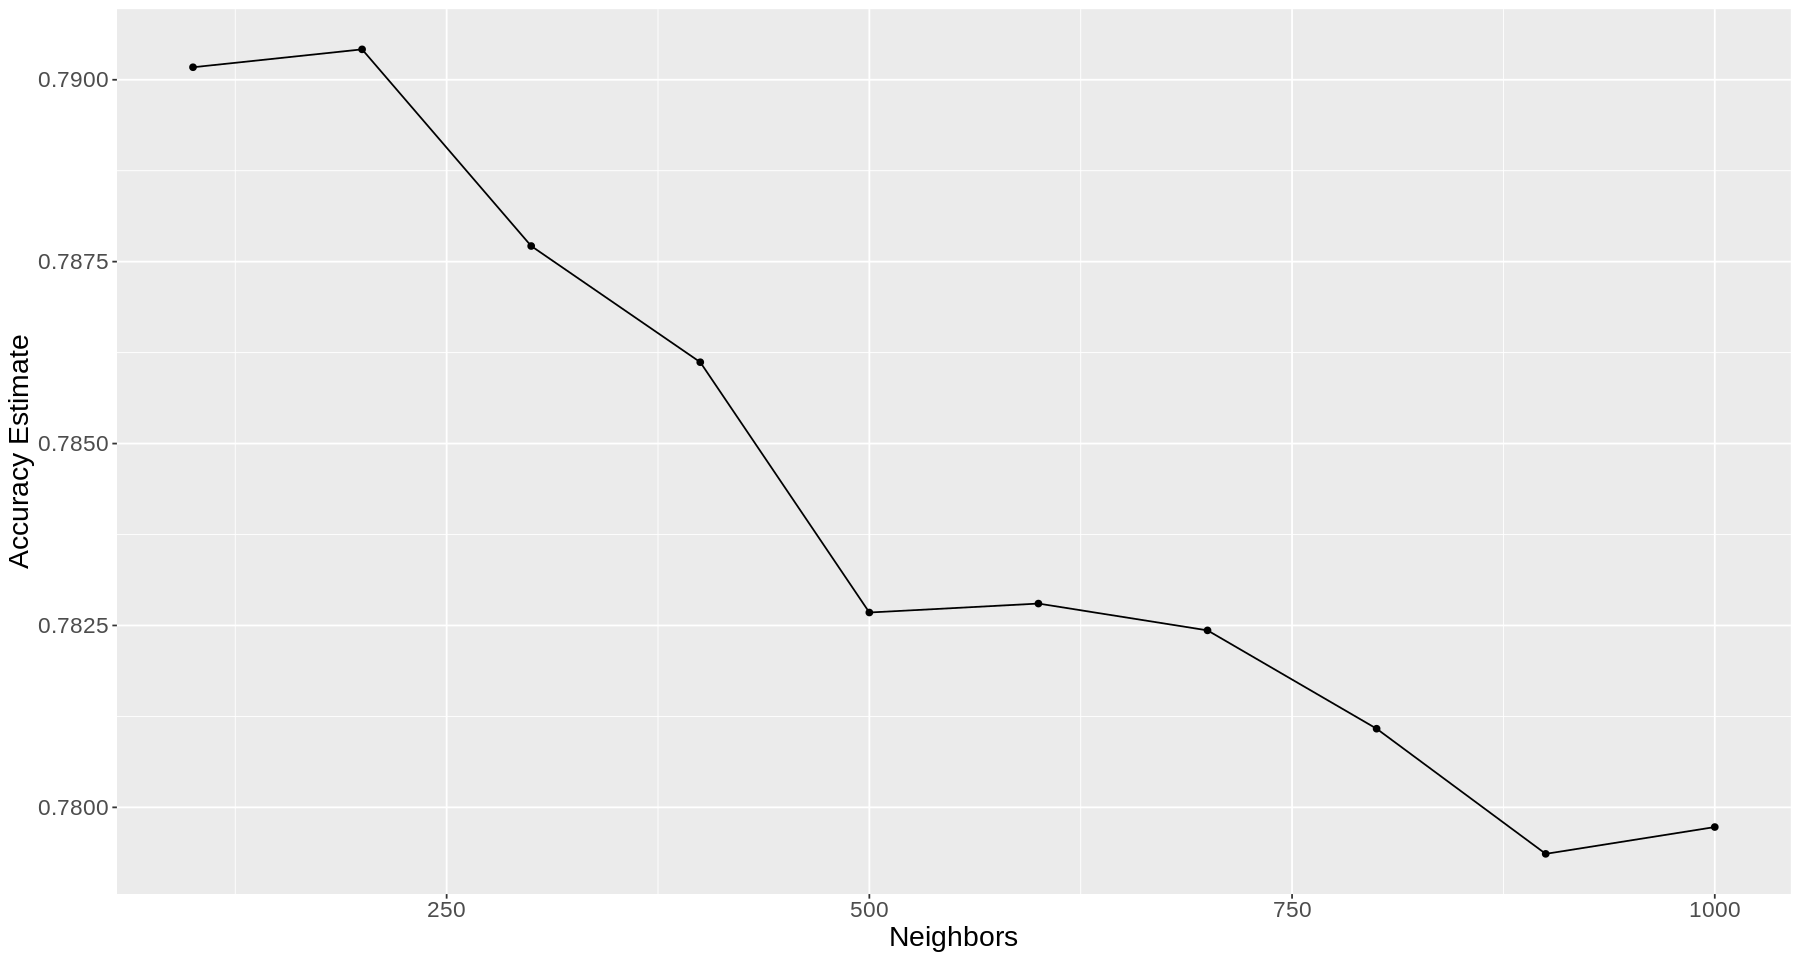

In [29]:
# Graph of neighbours versus mean accuracy 

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 17))
accuracy_vs_k

_Figure 12: KNN neighbors versus prediction accuracies_

In [30]:
# KNN classification testing

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 250) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

tennis_fit <- workflow() %>%
    add_recipe(tennis_recipe) %>%
    add_model(knn_spec) %>%
    fit(tennis_train_final)

tennis_predict <- predict(tennis_fit, tennis_test_final)%>%
    bind_cols(tennis_test_final)

In [31]:
# Create an accuracy output table 

tennis_metrics <- tennis_predict %>% 
    metrics(truth = Outcome, estimate = .pred_class)
tennis_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7812223
kap,binary,0.5623914


_Table 7: Accuracy of prediction model on testing set_

In [32]:
# Create a confusion matrix

tennis_conf_mat <- tennis_predict %>%
    conf_mat(truth = Outcome, estimate = .pred_class)      
tennis_conf_mat 

          Truth
Prediction    W    L
         W 1394  439
         L  302 1252

_Table 8: Confusion matrix of prediction model on testing set_

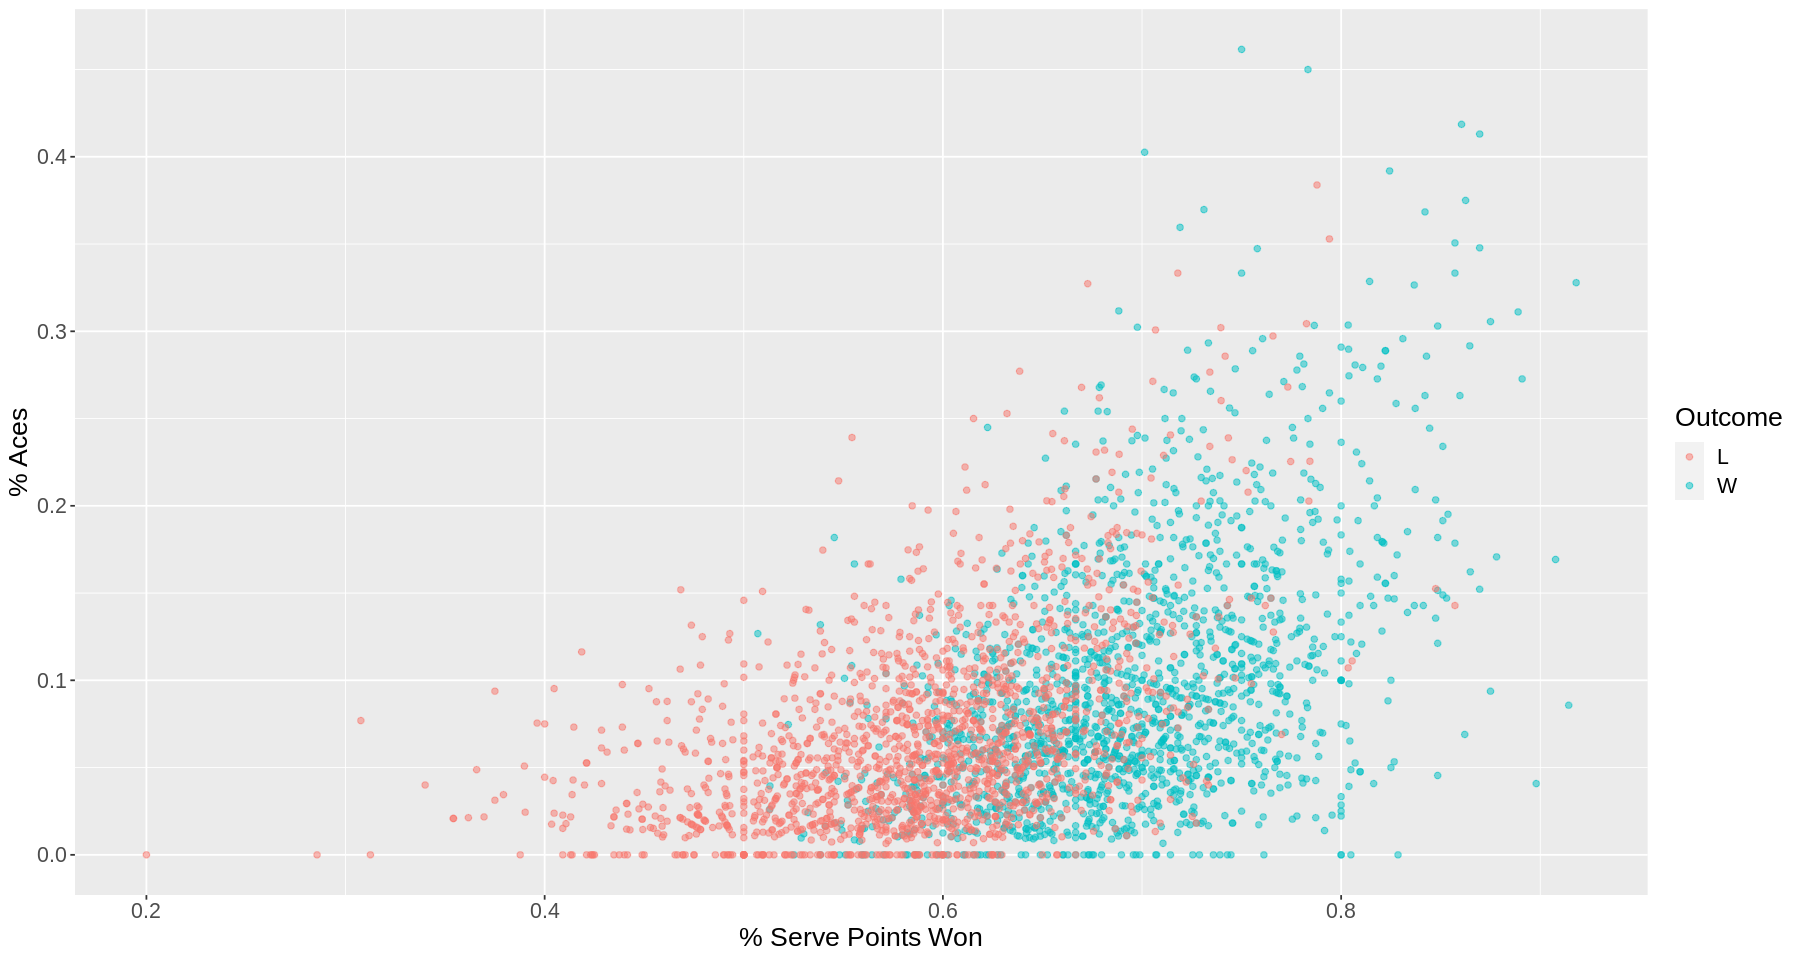

In [33]:
# Classification analysis plot 1: serve category 

tennis_predict$Outcome <- factor(tennis_predict$Outcome, levels = c("L", "W"))

serve_g <- tennis_predict %>%
    ggplot(aes(x = svptwinp, y = acep, color = Outcome)) +
    geom_point(alpha = 0.5) +
    labs(x = "% Serve Points Won", 
    y = "% Aces",
    color = "Outcome") +
    theme(text = element_text(size = 16)) +
    scale_color_manual(values = c("L" = "#F8766D", "W" = "#00BFC4"))
serve_g

_Figure 13: Percentage of serve point won vesus percentage of aces colored by match outcome_

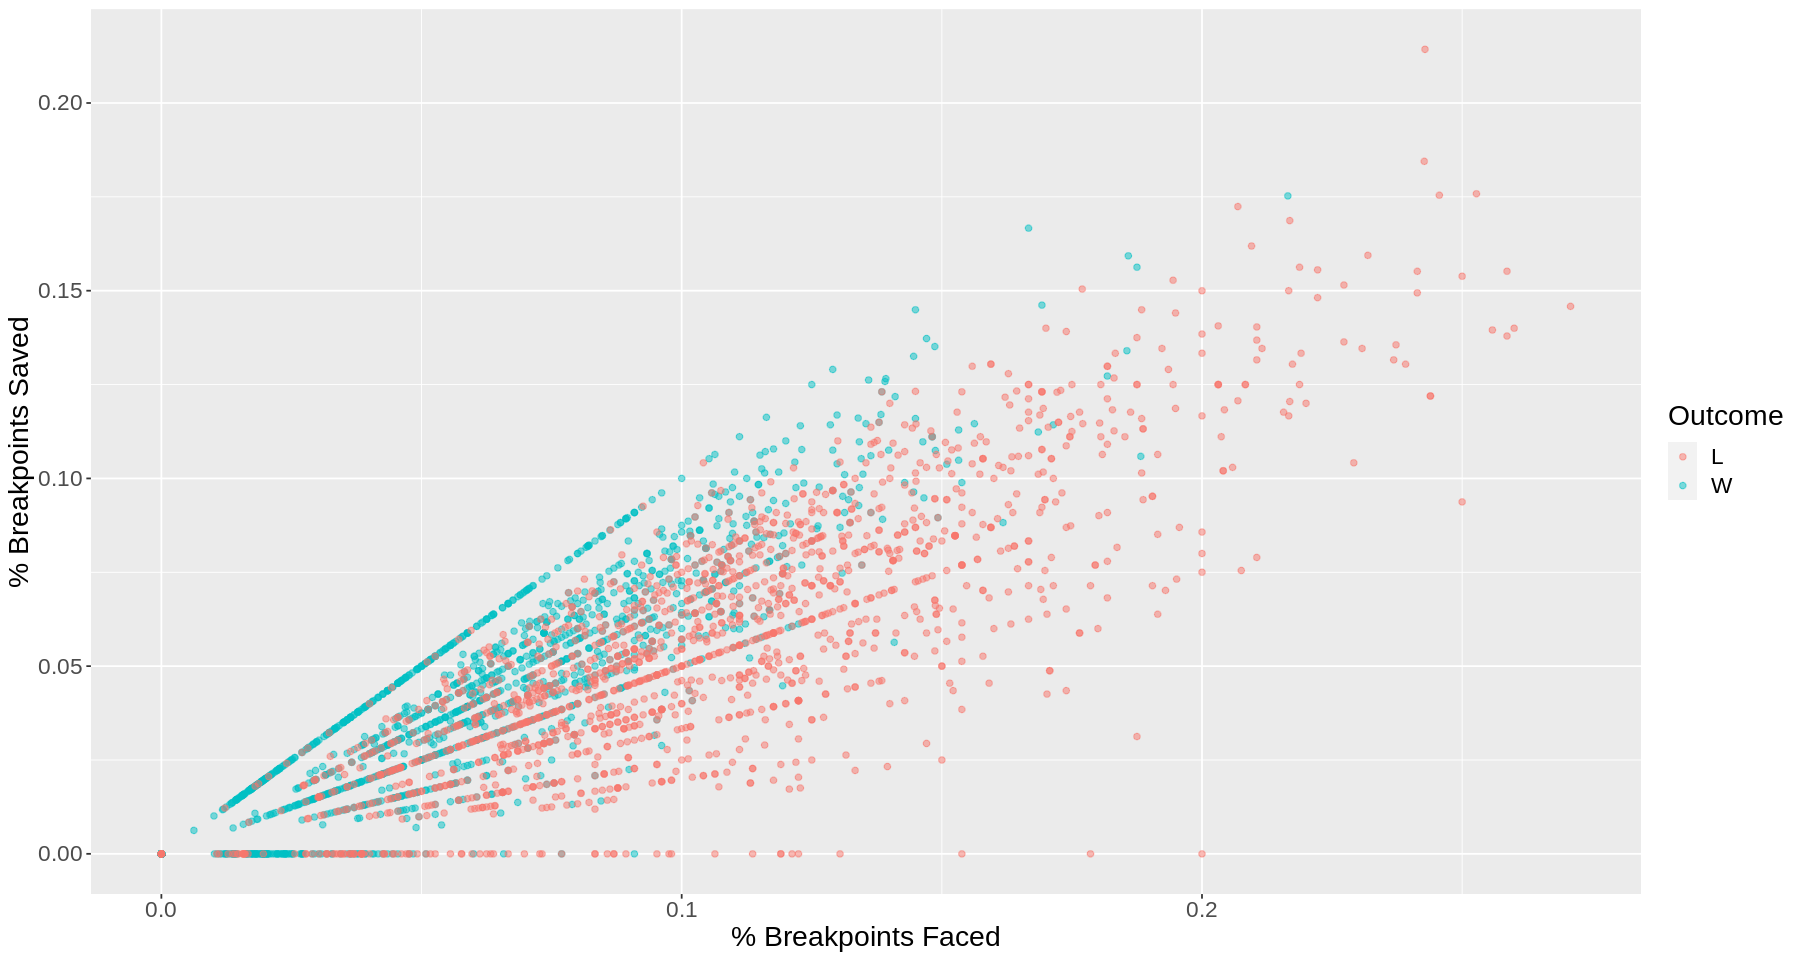

In [34]:
# Classification analysis plot 2: break point category 

bp_g <- tennis_predict %>%
    ggplot(aes(x = bpfacep, y = bpsavedp, color = Outcome)) +
    geom_point(alpha = 0.5) +
    labs(x = "% Breakpoints Faced", 
    y = "% Breakpoints Saved",
    color = "Outcome") +
    theme(text = element_text(size = 17))+
scale_color_manual(values = c("L" = "#F8766D", "W" = "#00BFC4"))
bp_g

_Figure 14: Percentage of breakpoints faced versus percentage of breakpoint saved colored by match outcome_

### DISCUSSION

From the analysis visualization, we see that players have a higher chance of winning the match if they have a higher percentage of serve points won, a higher percentage of aces, more breakpoints saved, and less breakpoints faced. 

The results match our predicted outcome, as we expected that a player with stronger statistics would have a higher chance of winning the match. This prediction is supported in both Figure 13 and Figure 14. Figure 13 compares percentage of serve points won and percentage of aces, showing that players who have more serve points won will also have more aces. Since aces are scored when opposing players are unable to receive the players’ serve, it would make sense that these two variables would have a strong correlation. In Figure 14, we can observe that players who save more breakpoints and face less breakpoints have a higher chance of winning. This is also logical since breakpoints are the ‘final points’ that determine the outcome of a game, which ultimately impact the outcome of the match. If the player were to save more breakpoints, it means that they are less likely to lose the game and thus the match. Conversely, the more breakpoints a player faces, the more chances they will have to potentially mess up and lose the breakpoint. In conclusion, players' statistics during a match will largely influence their probability of winning. If a player has good match statistics as defined by our model, then their win rate would be higher than those with relatively lower statistics. 

This data analysis can have an impact on the training of tennis players. If certain match statistics are found to increase the chance of winning a match, players could focus on training those skills. Additionally, the data could also benefit school scouting and audiences who participate in betting. Using previous match statistics or data from early matches, participants could more accurately place money on the winning player. 

**Future questions that could be investigated:**
- Are there statistics that were not included in the dataset that can improve the effectiveness of our KNN model?
- Could these predictions be used to find rank difference, winner rank and loser rank?
- Are there other classification methods that could have been used to produce a model with higher accuracy considering the limitation of KNN classifications with large data sets?
- Since serve indicators are so important in any given match, how could we predict player serve win percentage given certain parameters (and what parameters would we choose)? [4]
- Can player skill rating (ELO) be taken into consideration to produce more advanced predictions based on opponent strength? [4]

### REFERENCES
[1] Sackmann, J. (2020). ATP Tennis Rankings, Results, and Stats. https://github.com/JeffSackmann/tennis_atp

[2] Sackmann, J. (2020, March 4). _Tennis Data Dictionary._ Retrieved from https://count.co/notebook/j0OYDOaWDmn 

[3] De Seranno, A. (2020). Predicting Tennis Matches Using Machine Learning (dissertation). Ghent University, Ghent. 

[4] Gollub, J. (2021). Forecasting serve performance in professional tennis matches. _Journal of Sports Analytics, 7_(4), 223–233. https://doi.org/10.3233/jsa-200345 